In [ ]:
# Notebook: TensorFlow Keras Tabular Data Regression
# Author: Thomas Purk
# Date: 2025-04-11
# Reference: https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html
# Reference: https://www.tensorflow.org/tutorials/keras/regression
# Reference:

# TensorFlow Keras Tabular Data Regression

Train a deep learning model to predict the median house value based on the numeric features of SciKit Learns popular California Housing dataset. The technique shown here produces a basic linear regression, where the neural network has one layer configured with the default linear activation function a(x) = x.


**Dataset***

> This dataset was derived from the 1990 U.S. census, using one row ***per census***
block group. A block group is the smallest geographical unit for which the U.S.
Census Bureau publishes sample data (a block group typically has a population
of 600 to 3,000 people).

https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

In [ ]:
# Notebook Setup

# Data, Arrays, Linear Algebra
import numpy as np
import pandas as pd

# Visualization & Mapping
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Add for better Jupyter Notebook compatibility
%matplotlib inline

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Data
from sklearn.datasets import fetch_california_housing

# Prevent Pandas and other warnings from displaying above outputcells, improve readability
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once') # See warnings one time

## Data Collection and Loading

In [ ]:
# Load Data
cali_housing_bunch = fetch_california_housing(as_frame=True)

# Validate
print(cali_housing_bunch.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [ ]:
# View Bunch Keys
cali_housing_bunch.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [ ]:
# View Target Names and Item
print(cali_housing_bunch['target_names'])
print('')
print(cali_housing_bunch['target'])

['MedHouseVal']

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64


**NOTE:** From DESC property

>The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

In [ ]:
# Setup a Dataframe
df = cali_housing_bunch.frame

# Validate
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Exploratory Data Analysis

In [ ]:
# Notes
# A first pass modeling training, evaluation, and vizualization cycle show good results but hints of outliers.
# A second pass at data pre-processing and subsequent steps is made in attempt to handle outliers

In [ ]:
# Structural Metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
# Observations
# - all features are 100% popualted
# - all features are numeric floating point
# - Over 20,000 records

In [ ]:
# Summary Statistics
print(df.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude   MedHouseVal  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

In [ ]:
# Observations
# - AveRooms, AveBedrms, and AveOccup show max values far outside the std of mean and even the 75 percentile
# - This could make sense because of the population variation among census blocks
# - This variation is manifest in the summary stats of the Population column
# - The DESC property gives some reasoning for the variation as well

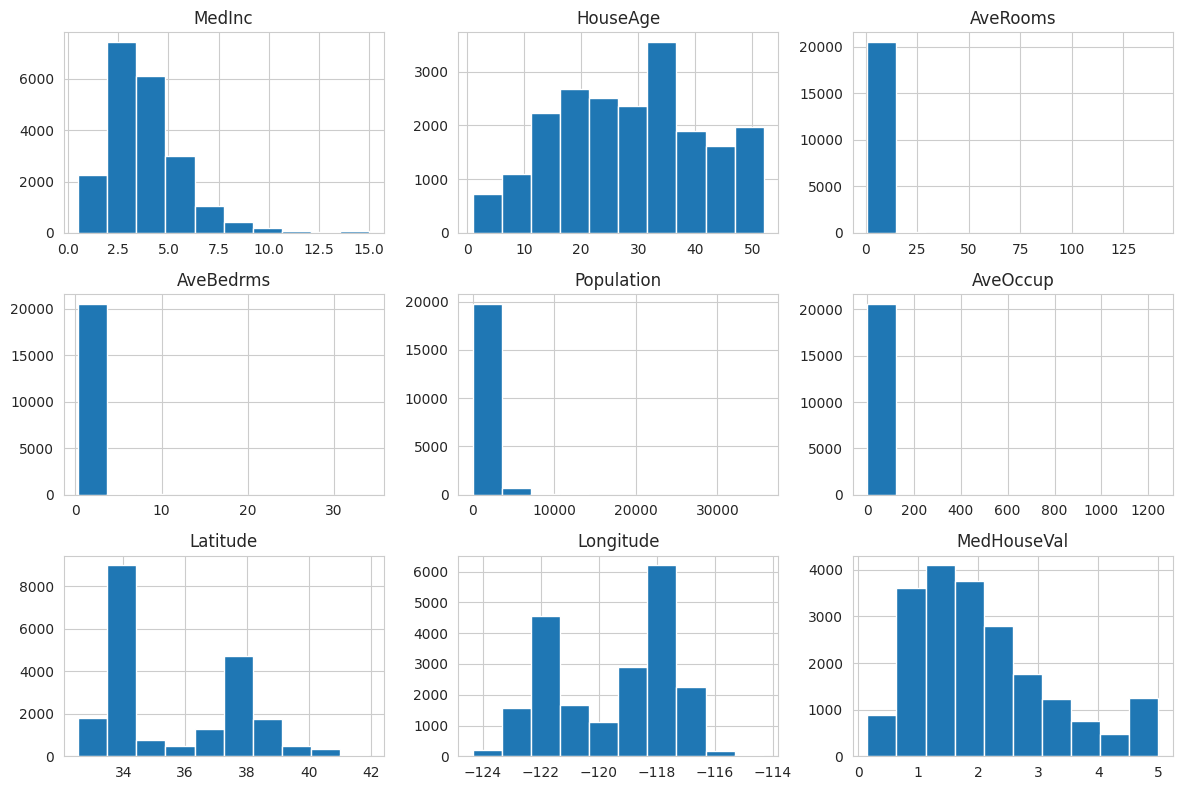

In [ ]:
# Explore a basic histogram of features
df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [ ]:
# Observations
# - The outliers in AveRooms, AveBedrms, and AveOccup are even more obvious in the charts
# - The Latitue and Longitude columns show a potential for both high and low geospatial densities.

In [ ]:
# Explore Population clusters

# Center map around the the average coordinate
avg_location = (df['Latitude'].mean(), df['Longitude'].mean())

# Prepare heat map data as a list of [lat, lon] points
heat_data = df[['Latitude', 'Longitude', 'Population']].values.tolist()

housing_heat_map = folium.Map(location=avg_location, zoom_start=6)

# Add markers
HeatMap(heat_data, radius=8, blur=15, max_zoom=10).add_to(housing_heat_map)

# Show map
housing_heat_map

Text(0.5, 1.0, 'Feature Correlation')

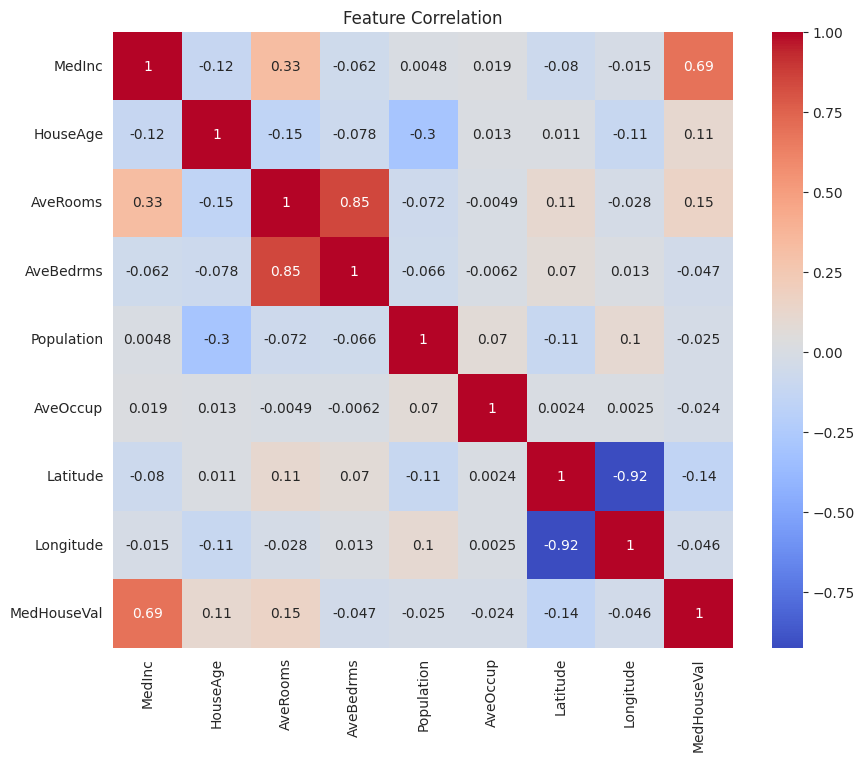

In [ ]:
# Correlation heatmap

#list(plt.colormaps)

plt.figure(figsize=(10, 8))
sns.heatmap(
    data=df.corr(),
    annot=True,
    cmap='coolwarm')

plt.title("Feature Correlation")


In [ ]:
# Observations:
# - MedInc shows the strongest influence on MedHouseVal
# - AveRooms shows thes second strongest influence.
# - MedInc and AveRooms also seem to have some correlation.

## Preprocessing, Normalization, and Cleaning

In [ ]:
df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')

In [ ]:
# Second Pass
# Apply the Interquartile Range (IQR) Outlier Removal Method
# 'AveRooms', 'AveBedrms', 'Population', 'AveOccup'

def iqr_filter(df, feature_name):

    # Q1, Q3, and IQR
    q1 = df[feature_name].quantile(0.25)
    q3 = df[feature_name].quantile(0.75)
    iqr = q3 - q1

    # Bounds
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Filter data
    return df[(df[feature_name] >= lower) & (df[feature_name] <= upper)]


df_norm = iqr_filter(df, 'AveRooms')
df_norm = iqr_filter(df_norm, 'AveBedrms')
df_norm = iqr_filter(df_norm, 'Population')
df_norm = iqr_filter(df_norm, 'AveOccup')

In [ ]:
# Validate outlier filtering
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17309 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       17309 non-null  float64
 1   HouseAge     17309 non-null  float64
 2   AveRooms     17309 non-null  float64
 3   AveBedrms    17309 non-null  float64
 4   Population   17309 non-null  float64
 5   AveOccup     17309 non-null  float64
 6   Latitude     17309 non-null  float64
 7   Longitude    17309 non-null  float64
 8   MedHouseVal  17309 non-null  float64
dtypes: float64(9)
memory usage: 1.3 MB


In [ ]:
# Define the dataset by removing the labels from the data frame
X = df_norm.drop("MedHouseVal", axis=1)

# Define a labels series by selecting only the labels feature
y = df_norm["MedHouseVal"]

# Create training and test datasets and labels
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [ ]:
# Feature scaling
scaler = StandardScaler()

# Train the scaler on the training dataset
scaler.fit(X_train)

# Scale the training and test datasets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Building & Training

In [ ]:
# Create the model

model = Sequential()

layer1 = Dense(
    units=1,                           # 1 Nueron, One ouput value ('feature') per row
    input_shape=[X_train.shape[1]]     # The number of features input to the layer.
)

# For a linear regression only one layer is needed in the nueral network
model.add(layer1)

# Compile
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Define EarlyStopping callback
early_stop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


# Train
history = model.fit(
    x=X_train_scaled,
    y=y_train,
    epochs=100,
    callbacks=early_stop_cb,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.8105 - mae: 2.0923 - val_loss: 4.2016 - val_mae: 1.8104
Epoch 2/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.7658 - mae: 1.7138 - val_loss: 2.8860 - val_mae: 1.4836
Epoch 3/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5530 - mae: 1.3940 - val_loss: 2.0425 - val_mae: 1.2094
Epoch 4/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8031 - mae: 1.1364 - val_loss: 1.4507 - val_mae: 0.9777
Epoch 5/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3046 - mae: 0.9209 - val_loss: 1.0452 - val_mae: 0.7912
Epoch 6/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9287 - mae: 0.7456 - val_loss: 0.7796 - val_mae: 0.6538
Epoch 7/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7000 - mae: 0.6245 - val_loss: 0.6161 - val_mae: 0.5658
Epoch 8/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5700 - mae: 0.5484 - val_loss: 0.5253 - val_mae: 0.5181
Epoch 9/100
347/347 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

## Model Evaluation

In [ ]:
# First pass results before outlier filtering
# Test Mean Absolute Error: 0.533
# Test Loss: 0.548

# Evaluate Loss and Mean Absolute Error

loss, mae = model.evaluate(X_test_scaled, y_test)
print(f'Test Mean Absolute Error: {mae:.3f}')
print(f'Test Loss: {loss:.3f}')

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3939 - mae: 0.4622
Test Mean Absolute Error: 0.464
Test Loss: 0.403


In [ ]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,mae,val_loss,val_mae
0,5.206828,1.987733,4.201626,1.810439
1,3.403374,1.627562,2.886007,1.483641
2,2.380686,1.336300,2.042458,1.209354
3,1.682820,1.085385,1.450694,0.977732
4,1.195613,0.874720,1.045222,0.791154


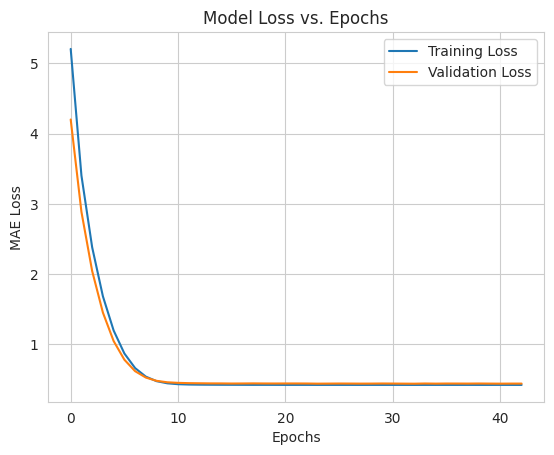

In [ ]:
# Visualize loss as a line plot

# Loss Series
sns.lineplot(
    x=history_df.index,
    y='loss',
    data=history_df,
    label='Training Loss'

)

# Validation Loss Series
sns.lineplot(
    x=history_df.index,
    y='val_loss',
    data=history_df,
    label='Validation Loss'
)

plt.title('Model Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()

## Predictions & Visualization

In [ ]:
# Predictions
y_pred = model.predict(X_test_scaled)
y_pred = y_pred.flatten()

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


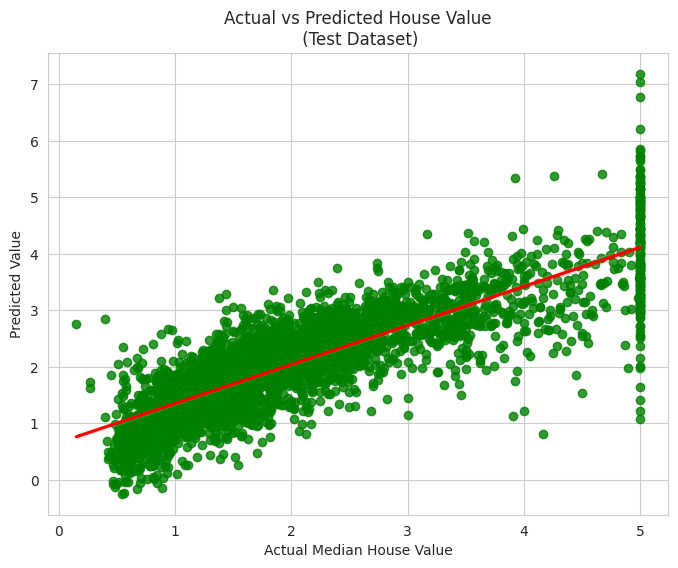

In [ ]:
# Vizualize model performance
# Test Set Actual vs Predicted Plot

plt.figure(figsize=(8, 6))

sns.regplot(
    x=y_test,
    y=y_pred,
    color="green", # dot color
    line_kws=dict(color="r"), # regression line color

)

plt.title("Actual vs Predicted House Value\n (Test Dataset)")

plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Value")

plt.show()

In [ ]:
# Observations (original)
# - Strong relationship
# - Clustering of off predictions for $500K homes
# - Possible indication of outiers

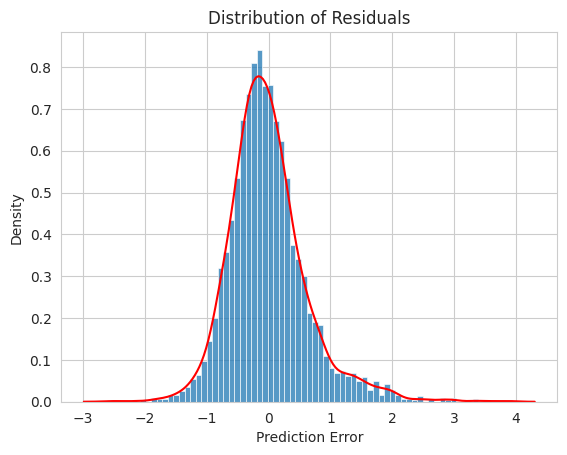

In [ ]:
# Residuals
residuals = y_test - y_pred

hist_axis = sns.histplot(
    data=residuals,
    stat='density'
)
sns.kdeplot(
    data=residuals,
    color='red',
    ax=hist_axis
)

plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error")

plt.show()

In [ ]:
# Observations (First Pass)
# - Bell shape-ish curve centered just below zero
# - Hint of a long tail on the positive side.
# - Model is effective but could be affected by some outliers.

# Observations (After Outlier Filtering)
# - Better MAE and Loss
# - Minor improvements in the regression or residual plts